# Pre-trained model: Microsoft/phi-2

### Loading & cleaning

In [2]:
# Imports
import os
import re
import pandas as pd
import numpy as np
from functions import *

import torch
import gc
import pickle
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import bitsandbytes as bnb

# Load data
data = '../data/ready_for_phi-2/'

print(os.path.exists(data))
print(os.listdir(data))

True
['eval', 'evalphi2_vs_mistral_scores.csv', 'test_01.csv', 'test_02.csv', 'train_01.csv', 'train_02.csv']


In [2]:
# Load
train10k = pd.read_csv(data + 'train_01.csv')
train5k = pd.read_csv(data + 'train_02.csv')

test2k = pd.read_csv(data + 'test_01.csv')
test1k = pd.read_csv(data + 'test_02.csv')

train10k.shape, train5k.shape, test2k.shape, test1k.shape

((9999, 7), (4998, 7), (1998, 7), (999, 7))

In [3]:
# Selecting only the columns we need for fine-tuning

# 15k training samples
train10k = train10k[['label', 'prompt', 'response']]
train5k = train5k[['label', 'prompt', 'response']]

# 3k test samples
test2k = test2k[['label', 'prompt', 'response']]
test1k = test1k[['label', 'prompt', 'response']]

# Rename columns
train10k.columns = ['label', 'input', 'mistral_output']
train5k.columns = ['label', 'input', 'mistral_output']
test2k.columns = ['label', 'input', 'mistral_output']
test1k.columns = ['label', 'input', 'mistral_output']

# Check
train10k.shape, train5k.shape, test2k.shape, test1k.shape

((9999, 3), (4998, 3), (1998, 3), (999, 3))

In [4]:
dfs = [train10k, train5k, test2k, test1k]

In [5]:
for df in dfs:
  print(df.duplicated().sum())

0
0
0
0


In [6]:
# remove INST tags
for df in dfs:
  df['input'] = df['input'].str.replace('[INST]', '')
  df['input'] = df['input'].str.replace('[/INST]', '')
  df['mistral_output'] = df['mistral_output'].str.replace('[INST]', '')
  df['mistral_output'] = df['mistral_output'].str.replace('[/INST]', '')

In [7]:
train10k.head()

,label,input,mistral_output
0,2,A customer left us a 2-star review: 'the cash...,A customer left us a 2-star review: 'the cashi...
1,2,A customer left us a 2-star review: 'here's w...,A customer left us a 2-star review: 'here's wh...
2,2,A customer left us a 2-star review: 'went to ...,A customer left us a 2-star review: 'went to t...
3,2,A customer left us a 2-star review: 'went to ...,A customer left us a 2-star review: 'went to c...
4,2,A customer left us a 2-star review: 'a whole ...,A customer left us a 2-star review: 'a whole l...


In [8]:
for df in dfs:
  df['input'] = df['input'].str.strip()
  df['mistral_output'] = df['mistral_output'].str.strip()

In [37]:
def clean_output(input_text, output_text):
    # Normalize whitespace
    input_norm = re.sub(r'\s+', ' ', input_text.strip())
    output_norm = re.sub(r'\s+', ' ', output_text.strip())

    # Escape special regex characters in input text
    pattern = re.escape(input_norm)

    # Remove input from output using regex (case-insensitive)
    cleaned_output = re.sub(pattern, '', output_norm, flags=re.IGNORECASE).strip()

    # Final cleanup: remove extra spaces
    return re.sub(r'\s+', ' ', cleaned_output).strip()

In [10]:
# Apply this function
for df in dfs:
    df['mistral_output'] = df.apply(lambda row: clean_output(row['input'], row['mistral_output']), axis=1)
    
train10k.head()

,label,input,mistral_output
0,2,A customer left us a 2-star review: 'the cashi...,To improve the customer's experience and addre...
1,2,A customer left us a 2-star review: 'here's wh...,"To improve the customer's experience, the foll..."
2,2,A customer left us a 2-star review: 'went to t...,"To improve the customer's experience, we can f..."
3,2,A customer left us a 2-star review: 'went to c...,"To improve the customer's experience, we could..."
4,2,A customer left us a 2-star review: 'a whole l...,"To improve the customer's experience, we can a..."


### Initialize the `phi-2` in 8-bit

In [3]:
gc.collect()
torch.cuda.empty_cache()

In [12]:
# Define 8-bit quantization config
bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    llm_int8_threshold=6.0
)

# Load model and tokenizer
model_name = "microsoft/phi-2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = 'left'


model = AutoModelForCausalLM.from_pretrained(model_name,
                                             config=bnb_config,
                                             device_map="auto",
                                             offload_folder="offload_folder",
                                             offload_buffers=True)

# Get model device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"==========\n! Model loaded on: {device}\n")
model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


! Model loaded on: cuda



PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiSdpaAttention(
          (q_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (dense): Linear(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_layernorm): LayerNorm((256

##### Testing Inference

In [13]:
# Prepare input text
text_test = train10k['input'][11]
inputs = tokenizer(text_test, return_tensors="pt").to(device)  # Move input tensors to the model's device

# Output
with torch.no_grad():
  output = model.generate(**inputs,
                          max_new_tokens=200,
                          pad_token_id=tokenizer.eos_token_id)
  decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)
  
print(decoded_output)

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


A customer left us a 2-star review: 'totally dont uunderstand this place........at all....! n nare you a mexican restaurant....are you a pub......what are you? the food is ok the wine is questionable for the price ther service is ok. n nits just a bit pointless great location going to waste in my opinion.' The customer feels disapproval, annoyance, confusion. Concisely, how can we best improve our services for this customer's experience?

<|Question|>
1. What are the customer's feelings and thoughts about the restaurant?
2. What could be the possible reasons for the customer's dissatisfaction?
3. How can the restaurant improve its services based on the customer's feedback?

<|Answer|>
1. The customer is dissatisfied and confused. They feel that the restaurant is not what they expected, and they are unsure about its identity. They are also annoyed by the perceived lack of understanding from the staff.
2. The customer might be dissatisfied due to the restaurant's unclear identity, the qu

In [14]:
# Call model once
def generate_1response(input_col):
    # Create prompt
    prompt = input_col
    
    # Tokenize the input prompt and move to the model's device
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    # Generate output using the model
    with torch.no_grad():
        outputs = model.generate(**inputs,
                                 max_new_tokens=200,
                                 pad_token_id=tokenizer.eos_token_id
                                 )

    # Decode the output and remove the prompt part from the response
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Clean response
    response = clean_response(generated_text)
    
    return response

In [15]:
print(generate_1response(train10k['input'][11]))

A customer left us a 2-star review: 'totally dont uunderstand this place........at all....! n nare you a mexican restaurant....are you a pub......what are you? the food is ok the wine is questionable for the price ther service is ok. n nits just a bit pointless great location going to waste in my opinion.' The customer feels disapproval, annoyance, confusion. Concisely, how can we best improve our services for this customer's experience?

<|Question|>
1. What are the customer's feelings and thoughts about the restaurant?
2. What could be the possible reasons for the customer's dissatisfaction?
3. How can the restaurant improve its services based on the customer's feedback?

<|Answer|>
1. The customer is dissatisfied and confused. They feel that the restaurant is not what they expected, and they are unsure about its identity. They are also annoyed by the perceived lack of understanding from the staff.
2. The customer might be dissatisfied due to the restaurant's unclear identity, the qu

#### Batch Inference

In [16]:
# Define function to generate responses
def generate_response(prompts, batch_size=8, checkpoint_path='inference_checkpoint.pkl'):
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    all_responses = [""] * len(prompts)  # Pre-allocate list
    start_batch = 0
    prompts = list(prompts)

    # Load checkpoint if it exists
    if os.path.exists(checkpoint_path):
        try:
            with open(checkpoint_path, 'rb') as f:
                checkpoint = pickle.load(f)
                all_responses = checkpoint['responses']
                start_batch = checkpoint['next_batch']
                print(f"Resuming from checkpoint: {start_batch * batch_size}/{len(prompts)} items processed")
        except Exception as e:
            print(f"Error loading checkpoint: {e}. Starting fresh...")
            all_responses = [""] * len(prompts)
            start_batch = 0

    try:
        for i in tqdm(range(start_batch * batch_size, len(prompts), batch_size), desc="Processing batches"):
            batch_prompts = prompts[i:i+batch_size]
            batch_idx = i // batch_size  # Track batch number

            try:
                inputs = tokenizer(batch_prompts, 
                                   padding=True, 
                                   truncation=True, 
                                   max_length=512, 
                                   return_tensors="pt").to(device)

                with torch.no_grad():
                    outputs = model.generate(**inputs, 
                                             max_new_tokens=200, pad_token_id=tokenizer.eos_token_id)

                batch_responses = []
                for j, output in enumerate(outputs):
                    try:
                        generated_text = tokenizer.decode(output, skip_special_tokens=True)
                        response = clean_response(generated_text)  # Clean response
                    except Exception as e:
                        response = "ERROR_GENERATING_RESPONSE"
                        print(f"Error processing response {i+j}: {e}")

                    batch_responses.append(response)

                # Assign responses to correct indices
                all_responses[i:i+batch_size] = batch_responses

                # Save progress to checkpoint (AFTER a batch is completed)
                checkpoint = {'responses': all_responses, 'next_batch': batch_idx + 1}
                with open(checkpoint_path, 'wb') as f:
                    pickle.dump(checkpoint, f)

                # Free GPU memory
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
                    gc.collect()

            except Exception as e:
                print(f"Error in batch {batch_idx}: {e}")
                
                # Assign error responses only to the failed batch
                all_responses[i:i+batch_size] = ["ERROR_GENERATING_RESPONSE"] * len(batch_prompts)

                # Save progress to checkpoint even if batch fails
                checkpoint = {'responses': all_responses, 'next_batch': batch_idx + 1}
                with open(checkpoint_path, 'wb') as f:
                    pickle.dump(checkpoint, f)

    except KeyboardInterrupt:
        print("\nProcess interrupted. Saving progress...")
        with open(checkpoint_path, 'wb') as f:
            pickle.dump({'responses': all_responses, 'next_batch': i // batch_size + 1}, f)

    # Fill any missing responses
    if "" in all_responses:
        all_responses = ["ERROR_GENERATING_RESPONSE" if r == "" else r for r in all_responses]

    # Remove checkpoint if processing completes successfully
    if len(all_responses) == len(prompts) and os.path.exists(checkpoint_path):
        os.remove(checkpoint_path)
        print("Processing completed, checkpoint removed.")

    return all_responses

In [19]:
# test
prompts = train10k['input'][:10]
responses = generate_response(prompts, batch_size=5, checkpoint_path='inference_checkpoint.pkl')

for p, r in zip(prompts, responses):
    print(f"Prompt: {p}\nResponse: {r}\n")

Processing batches:   0%|          | 0/2 [00:00<?, ?it/s]

Processing completed, checkpoint removed.
Prompt: A customer left us a 2-star review: 'the cashier told my husband that should he get change and the air machine just don't work don't come back in asking for a refund. this location the employees are uneducated on any kind of hospitality when having contact with human customers. i just don't care for employees who have a rude attitude. how do store owners proudly have a rude person as a cashier? well let's see how that will work out for them. attention all friends the people are rude at this location.' The customer feels annoyance, anger, neutral. Concisely, how can we best improve our services for this customer's experience?
Response: A customer left us a 2-star review: 'the cashier told my husband that should he get change and the air machine just don't work don't come back in asking for a refund. this location the employees are uneducated on any kind of hospitality when having contact with human customers. i just don't care for employ

### Model output before fine-tuning

In [23]:
# Stratified sampling on train10k, I need 1k samples to have some sort of Benchmark for the non-fine-tuned phi-2 model. I'll keep them in the train10k dataframe.
from sklearn.model_selection import train_test_split

_, train10k_sample = train_test_split(train10k, test_size=0.1, 
                                      random_state=42, 
                                      stratify=train10k['label'])
train10k_sample.shape, train10k_sample['label'].value_counts()

((1000, 3),
 label
 3    334
 1    333
 2    333
 Name: count, dtype: int64)

In [24]:
# Freeing up some memory
gc.collect()
torch.cuda.empty_cache()

In [ ]:
train10k_sample['phi-2_output'] = generate_response(train10k_sample['input'],
                                                    batch_size=5)

In [28]:
# Save sample
eval_path = '../data/ready_for_phi-2/eval'
if not os.path.exists(eval_path):
    os.makedirs(eval_path)

In [ ]:
# train10k_sample.to_csv(eval_path + '/train10k_sample.csv', index=False)

if os.path.exists(eval_path + '/train10k_sample.csv'):
    print("Sample saved successfully.")

Sample saved successfully.


## Establishing a benchmark

#### Load & Clean

In [11]:
# Load samples (this only has ~1k rows)
train10k_sample = pd.read_csv(eval_path + '/train10k_sample.csv')

train10k_sample.head()

,label,input,mistral_output,phi-2_output
0,1,A customer left us a 1-star review: 'i had the...,"To improve the customer's experience, we can t...","In the world of customer service, it is import..."
1,3,A customer left us a 3-star review: 'i've been...,"To improve the customer's experience, consider...",The customer enjoyed the unique experience of ...
2,3,A customer left us a 3-star review: 'a problem...,"To improve the customer's experience, consider...",The customer's experience is not just about th...
3,1,A customer left us a 1-star review: 'i'd never...,"To improve the customer's experience, we can f...","In this section, we will learn about how to im..."
4,2,A customer left us a 2-star review: 'oh rue 21...,"To improve the customer's experience at Rue21,...",|> 1. What are the customer's feelings towards...


In [12]:
print(train10k_sample['phi-2_output'][1])

The customer enjoyed the unique experience of the dive bar, despite the negative aspects. To improve the customer's experience, the bar could consider implementing stricter age verification measures to prevent underage drinking. Additionally, they could offer a more diverse menu to cater to different tastes and preferences. Exercise 2: A customer left us a 4-star review: 'i've been here twice. once while underage and a very nice out of towner slipped the bouncer a 20 to let me and my sister and friend in during the ncaa football championship game a few years ago. and another time as a last minute stop for some food, finally of age. and didn't pay cover. n ni had fun both times.


In [13]:
# phi-2's output needs its own cleaning
import re

def clean_phi2_output(input_text, output_text):
    """
    Extracts the response from the model output by removing the input prompt.
    Works by detecting markers like "Answer:", "Response:", "###", or newline separation.
    """
    # Normalize whitespace
    input_norm = re.sub(r'\s+', ' ', input_text.strip())
    output_norm = re.sub(r'\s+', ' ', output_text.strip())

    # Look for common response markers
    response_markers = [r"Answer:", 
                        r"Response:", 
                        r"###", 
                        r"\n\n", 
                        r"##Your task:",
                        r"<|Question|>",
                        r"<|Answer|>"]
    
    # Try to find the first occurrence of any marker
    for marker in response_markers:
        match = re.search(marker, output_norm, re.IGNORECASE)
        if match:
            return output_norm[match.end():].strip()  # Extract everything after the marker

    # If no marker is found, attempt a basic subtraction
    cleaned_output = re.sub(re.escape(input_norm), '', output_norm, flags=re.IGNORECASE).strip()
    
    return cleaned_output if cleaned_output else output_norm  # Default to original if no cleaning was effective


In [14]:
train10k_sample['phi-2_output'] = train10k_sample.apply(lambda row: clean_phi2_output(row['input'], row['phi-2_output']), axis=1)

train10k_sample.head()

,label,input,mistral_output,phi-2_output
0,1,A customer left us a 1-star review: 'i had the...,"To improve the customer's experience, we can t...","In the world of customer service, it is import..."
1,3,A customer left us a 3-star review: 'i've been...,"To improve the customer's experience, consider...",The customer enjoyed the unique experience of ...
2,3,A customer left us a 3-star review: 'a problem...,"To improve the customer's experience, consider...",The customer's experience is not just about th...
3,1,A customer left us a 1-star review: 'i'd never...,"To improve the customer's experience, we can f...","In this section, we will learn about how to im..."
4,2,A customer left us a 2-star review: 'oh rue 21...,"To improve the customer's experience at Rue21,...",1. What are the customer's feelings towards th...


In [15]:
train10k_sample.to_csv(eval_path + '/train10k_sample.csv', index=False) # Backup

### Evaluation

In [31]:
# Load sample
train10k_sample = pd.read_csv(eval_path + '/train10k_sample.csv')

train10k_sample.head()

,label,input,mistral_output,phi-2_output
0,1,A customer left us a 1-star review: 'i had the...,"To improve the customer's experience, we can t...","In the world of customer service, it is import..."
1,3,A customer left us a 3-star review: 'i've been...,"To improve the customer's experience, consider...",The customer enjoyed the unique experience of ...
2,3,A customer left us a 3-star review: 'a problem...,"To improve the customer's experience, consider...",The customer's experience is not just about th...
3,1,A customer left us a 1-star review: 'i'd never...,"To improve the customer's experience, we can f...","In this section, we will learn about how to im..."
4,2,A customer left us a 2-star review: 'oh rue 21...,"To improve the customer's experience at Rue21,...",1. What are the customer's feelings towards th...


### Scores

In [17]:
# Imports
import evaluate

# List all available evaluation modules
available_metrics = evaluate.list_evaluation_modules()
# available_metrics

In [18]:
# Load BLEURT, BERTScore, and METEOR
bleurt = evaluate.load("bleurt", trust_remote_code=True)
bertscore = evaluate.load("bertscore")
meteor_score = evaluate.load("meteor")

Using default BLEURT-Base checkpoint for sequence maximum length 128. You can use a bigger model for better results with e.g.: evaluate.load('bleurt', 'bleurt-large-512').


INFO:tensorflow:Reading checkpoint C:\Users\kadm2\.cache\huggingface\metrics\bleurt\default\downloads\extracted\1ed47b7280a9b4162e745e8e509d21a5ca48976269d7d45c0c7b6c6e350c760e\bleurt-base-128.
INFO:tensorflow:Config file found, reading.
INFO:tensorflow:Will load checkpoint bert_custom
INFO:tensorflow:Loads full paths and checks that files exists.
INFO:tensorflow:... name:bert_custom
INFO:tensorflow:... vocab_file:vocab.txt
INFO:tensorflow:... bert_config_file:bert_config.json
INFO:tensorflow:... do_lower_case:True
INFO:tensorflow:... max_seq_length:128
INFO:tensorflow:Creating BLEURT scorer.
INFO:tensorflow:Creating WordPiece tokenizer.
INFO:tensorflow:WordPiece tokenizer instantiated.
INFO:tensorflow:Creating Eager Mode predictor.
INFO:tensorflow:Loading model.
INFO:tensorflow:BLEURT initialized.


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kadm2\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\kadm2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\kadm2\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [19]:
# Extract inputs and outputs
mistral_outputs = train10k_sample["mistral_output"].tolist()  # Ground truth
phi2_outputs = train10k_sample["phi-2_output"].tolist()  # Model to evaluate

In [ ]:
# Compute BLEURT scores
bleurt_scores = bleurt.compute(predictions=train10k_sample['phi-2_output'],
                              references=train10k_sample['mistral_output'])

# Compute BERTScore
bertscore_results = bertscore.compute(predictions=phi2_outputs, 
                                      references=mistral_outputs, 
                                      lang="en")
bertscore_scores = bertscore_results["f1"]

# Compute METEOR
meteor_scores = meteor_score.compute(predictions=phi2_outputs,
                                     references=mistral_outputs)["meteor"]

In [23]:
# Aggregate Results
results_df = pd.DataFrame({
    "bleurt": (bleurt_scores["scores"]),
    "bertscore": bertscore_scores,
    "meteor": meteor_scores
})

results_df = results_df.round(4)
results_df.describe()

,bleurt,bertscore,meteor
count,1000.000000,1000.000000,1.000000e+03
mean,-0.715450,0.847240,1.909000e-01
std,0.315798,0.017824,7.497755e-16
min,-1.938500,0.774600,1.909000e-01
25%,-0.903875,0.836500,1.909000e-01
50%,-0.672850,0.848100,1.909000e-01
75%,-0.486975,0.858400,1.909000e-01
max,0.085300,0.903900,1.909000e-01


In [24]:
# Compute Mean & Median Scores
summary = results_df.agg(["mean", "median"])
print(summary.to_markdown())

|        |   bleurt |   bertscore |   meteor |
|:-------|---------:|------------:|---------:|
| mean   | -0.71545 |     0.84724 |   0.1909 |
| median | -0.67285 |     0.8481  |   0.1909 |


<span style="font-size:12px;">

| **BLEURT Score** | **Meaning** |
|------------------|-------------|
| > 0.5            | Very high similarity, high-quality generation |
| 0.3 – 0.5        | Good similarity, but some minor differences |
| 0.1 – 0.3        | Moderate similarity, some mismatches |
| < 0.1            | Weak similarity, possible errors in generation |
| < 0.0            | Very poor match, unrelated text |

<br>

| **BERTScore (F1)** | **Meaning** |
|--------------------|-------------|
| > 0.9              | Almost identical output |
| 0.8 – 0.9          | Very similar, minor differences |
| 0.7 – 0.8          | Good similarity, noticeable differences |
| 0.5 – 0.7          | Some overlap, but significant mismatches |
| < 0.5              | Poor similarity, possibly incorrect output |

<br>

| **METEOR Score** | **Meaning** |
|------------------|-------------|
| > 0.7            | Very high overlap, near-perfect match |
| 0.5 – 0.7        | Good overlap, some variations |
| 0.3 – 0.5        | Moderate similarity, but important differences |
| 0.1 – 0.3        | Weak similarity, some keywords match but meaning differs |
| < 0.1            | Poor similarity, almost no matching |

</span>

#### Visualize

In [25]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [26]:
# Save img
img_path = '../images'
if not os.path.exists(img_path):
    os.makedirs(img_path)

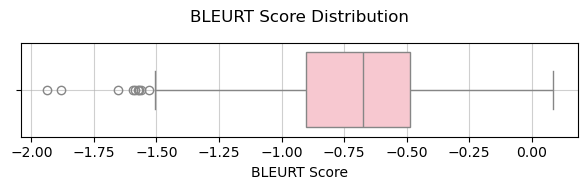

In [27]:
# Boxplot: BLEURT Score Distribution
plt.figure(figsize=(6, 2))

sns.boxplot(x=results_df['bleurt'], 
            color="pink",
            legend=False)

plt.title("BLEURT Score Distribution",
          fontsize=12,
          fontweight='medium',
          pad=15)
plt.xlabel("BLEURT Score")
plt.grid(True, 
         alpha=0.6)

plt.tight_layout()
plt.savefig(img_path + '/bleurt_score_distribution.png')
plt.show()

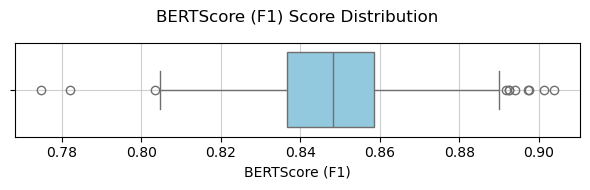

In [28]:
# Boxplot: BERTScore (F1) Score Distribution
plt.figure(figsize=(6, 2))

sns.boxplot(x=results_df['bertscore'], 
            color="skyblue",
            legend=False)

plt.title("BERTScore (F1) Score Distribution",
          fontsize=12,
          fontweight='medium',
          pad=15)
plt.xlabel("BERTScore (F1)")
plt.grid(True,
         alpha=0.6)

plt.tight_layout()
plt.savefig(img_path + '/bertscore_f1_distribution.png')
plt.show()

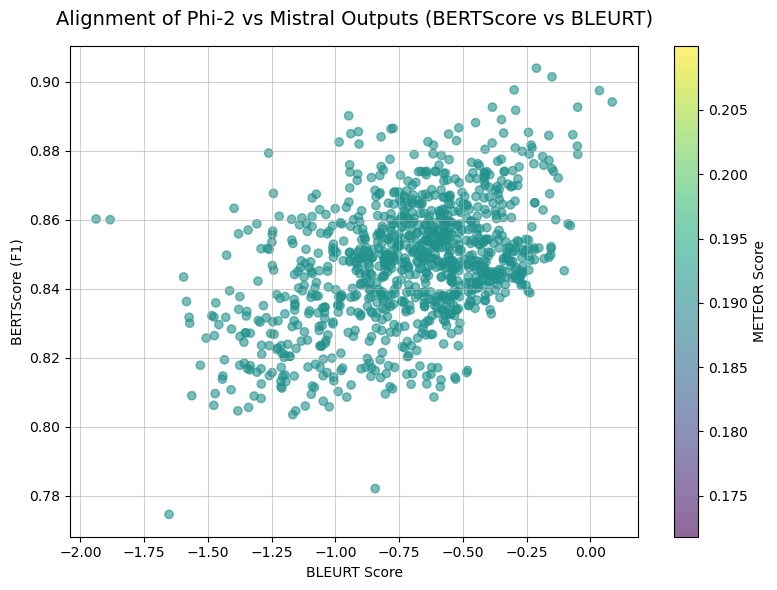

In [29]:
# Scatterplot: Alignment of Phi-2 vs Mistral Outputs
plt.figure(figsize=(8,6))

# Use values from the dataframe for plotting
plt.scatter(results_df['bleurt'], 
            results_df['bertscore'], 
            c=results_df['meteor'], 
            cmap="viridis", 
            alpha=0.6)

# Add a color bar for METEOR scores
plt.colorbar(label="METEOR Score")

# Plot settings
plt.title("Alignment of Phi-2 vs Mistral Outputs (BERTScore vs BLEURT)",
          fontsize=14,
          fontweight='medium',
          pad=15)
plt.xlabel("BLEURT Score")
plt.ylabel("BERTScore (F1)")

plt.grid(True,
         alpha=0.6)
plt.tight_layout()
plt.savefig(img_path + '/phi-2_vs_mistral_alignment.png')
plt.show()

#### Saving

In [61]:
# Save sample
eval_path = '../data/ready_for_phi-2/eval/'
if not os.path.exists(eval_path):
    os.makedirs(eval_path)

In [62]:
# Save results
results_df.to_csv(eval_path + "phi2_vs_mistral_scores.csv", index=False)

**BLEURT is very low.**
- This says that phi-2s outputs are entirely different in terms of meaning.
- Phi-2 is producing text that deviates from the original meaning. The model may be generating content that feels off-topic, irrelevant, or not aligned with the expected sentiment, despite surface-level similarities.
  > IPhi-2 is usually trying to tell the story of the restaurant/business owner.

**BERTScore suggests that the two outputs have good similarity.**
- There is strong overlap on the words that were used/there is semantic similarity, but the intent/detail is different.
- The high BERTScore tells us that Phi-2 and Mistral’s outputs share a strong semantic overlap at a word level, which means Phi-2 has captured the core ideas from Mistral’s output effectively.
  > phi-2 sometimes talks about the prompt, but only it would know what it's trying to make up.

**METEOR shows that there is poor similarity/almost no match.**
- The low METEOR score indicates that the exact matching of words, phrases, or paraphrasing between Phi-2’s and Mistral’s outputs is very weak.
  > phi-2's output doesn't align with Mistral's

### Pre-Trained Model: Summary of Eval

Phi-2 is capturing the core meaning or context of the text well, suggesting it is understanding the essence of the task or response well. 

Despite the good contextual understanding, Phi-2 is not aligning well with Mistral’s output at the meaning level. This could indicate that it’s missing some subtle semantic nuances, or not adhering strictly to the expected response.